# Preprocess data for HiRiD dataset to feed into model

In [1]:
import pandas as pd
import numpy as np

path = "data/hirid/raw_stage/observation_tables"
index_df = pd.read_csv(f"{path}/observation_tables_index.csv")
general_df = pd.read_csv("data/hirid/reference_data/general_table.csv")

In [2]:
general_df.head()

patientid        admissiontime sex  age discharge_status
0          1  2197-04-03 19:15:00   M   75            alive
1          2  2117-10-18 22:35:00   M   80            alive
2          3  2163-10-17 19:15:00   M   55            alive
3          4  2149-01-08 15:30:00   M   75            alive
4          5  2144-06-06 16:15:00   M   20            alive

In [3]:
index_df.head()

patientid  part
0          1    43
1          2    74
2          3    51
3          4   102
4          5   216

In [4]:
index_df.shape

(33904, 2)

In [5]:
general_df.shape

(33905, 5)

In [6]:
alive_id = general_df[general_df["discharge_status"] == 'alive']['patientid']
dead_id = general_df[general_df["discharge_status"] == 'dead']['patientid']
print(f"There are {len(alive_id)} alive patients\nThere are {len(dead_id)} dead patients\nMortality Rate: {100*len(dead_id) / (len(alive_id) + len(dead_id)):.2f}%")

There are 31604 alive patients
There are 2062 dead patients
Mortality Rate: 6.12%


In [7]:
import dask.dataframe as dd

class Extractor:
    def __init__(self, index_df, path="data/hirid/raw_stage/observation_tables/csv"):
        self.index_df = index_df
        self.path = path
    
    def get_patient(self, patient_id, mode='dask'):
        assert patient_id in self.index_df['patientid'].values, "patient_id not found"
        row = self.index_df[self.index_df['patientid'] == patient_id]
        part = int(row['part'])
        if mode == 'pandas':
            df = pd.read_csv(f"{self.path}/part-{part}.csv")
        elif mode == 'dask':
            df = dd.read_csv(f"{self.path}/part-{part}.csv", dtype={'stringvalue': 'object', 'type': 'object'})
        df = df[df['patientid'] == patient_id]
        return df
    
    def get_feature(self, patient_id, variable_id_arr, mode='dask'):
        patient_df = self.get_patient(patient_id, mode=mode)
        feature_df = patient_df[patient_df['variableid'].isin(variable_id_arr)]
        
        if isinstance(feature_df, pd.DataFrame):
            return feature_df
        elif isinstance(feature_df, dd.DataFrame):
            return feature_df.compute()

In [8]:
extractor = Extractor(index_df)

## Visualize Alive Patients

In [25]:
HEARTRATE_ID = [200]        # heartrate
SYSBP_ID = [100]            # Invasive systolic arterial pressure
DIABP_ID = [120]            # Invasive diastolic arterial pressure
MAP_ID = [110]                # Invasive mean arterial pressure
SATURATION_ID = [4000, 8280]        # Peripheral oxygen saturation
ST_ID = [210, 211, 212]        # ST elevation
CVP_ID = [700, 15001441, 960]    # CVP

======== [200] ========
Patient 0 done
Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 50 done
Patient 60 done
Patient 70 done
Patient 80 done
Patient 90 done


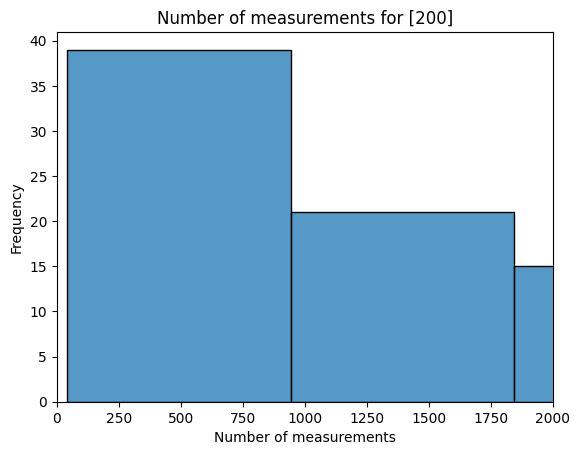

======== [100] ========
Patient 0 done
Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 50 done
Patient 60 done
Patient 70 done
Patient 80 done
Patient 90 done


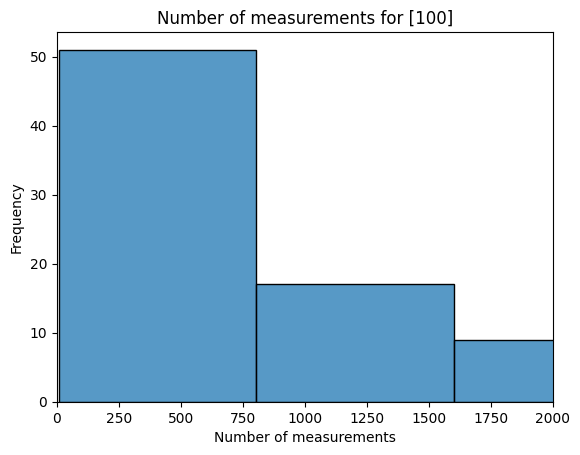

======== [120] ========
Patient 0 done
Difference is above threshold, 90th percentile is 2.08604
Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 50 done
Patient 60 done
Patient 70 done
Patient 80 done
Patient 90 done


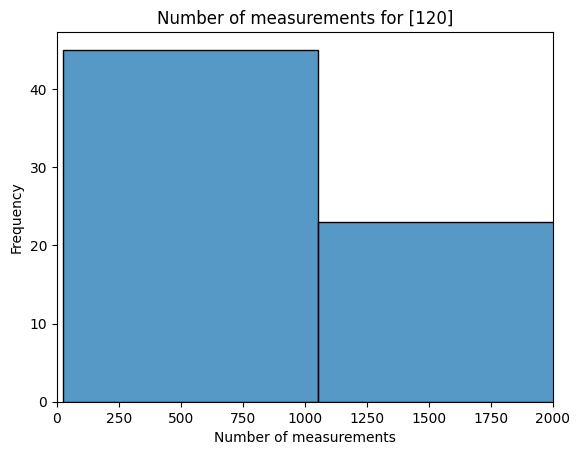

======== [110] ========
Patient 0 done
Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 50 done
Patient 60 done
Patient 70 done
Patient 80 done
Patient 90 done


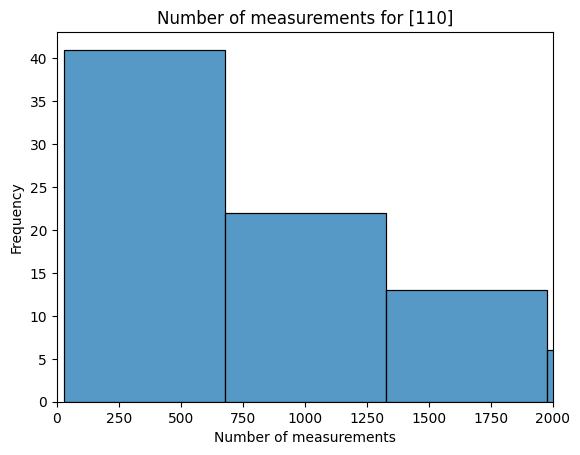

======== [4000, 8280] ========
Patient 0 done
Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 50 done
Patient 60 done
Patient 70 done
Patient 80 done
Patient 90 done


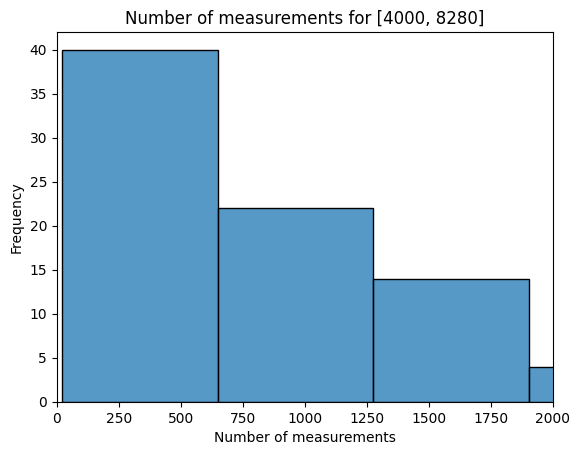

======== [210, 211, 212] ========
Patient 0 done
Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 60 done
Patient 70 done
Patient 90 done


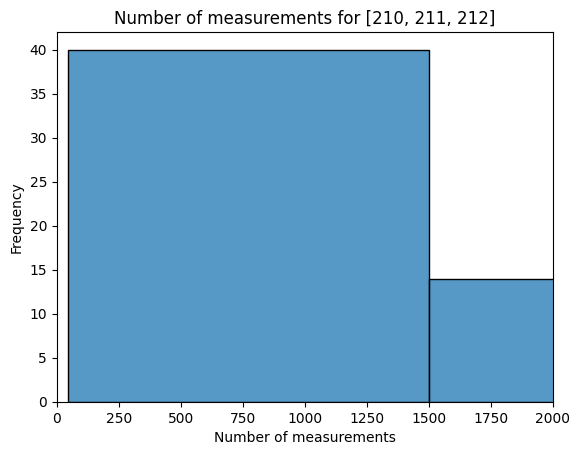

======== [700, 15001441, 960] ========
Patient 0 done
Patient 10 done
Patient 20 done
Patient 40 done
Patient 50 done
Difference is above threshold, 90th percentile is 856.6212
Patient 60 done
Patient 90 done


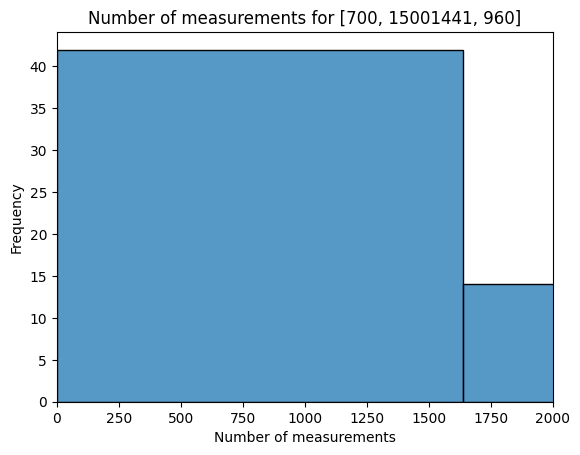

In [26]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import random
warnings.filterwarnings("ignore")

for feature_arr in [HEARTRATE_ID, SYSBP_ID, DIABP_ID, MAP_ID, SATURATION_ID, ST_ID, CVP_ID]:
    print(f"======== {feature_arr} ========")
    num_measurements = []
    for i, patient in enumerate(random.sample(list(dead_id), 100)):
        df = extractor.get_feature(patient, feature_arr)
        df['entertime'] = pd.to_datetime(df['entertime'])
        df['time_difference'] = df['entertime'].diff()
        df['time_difference'] = df['time_difference'].dt.total_seconds() / 60
        if len(df) == 0:
            continue
        if df['time_difference'].quantile(0.8) <= 2.01:
            pass
        else:
            print(f"Difference is above threshold, 90th percentile is {df['time_difference'].quantile(0.9)}")
        num_measurements.append(len(df))

        if i % 10 == 0:
            print(f"Patient {i} done")

    sns.histplot(num_measurements)
    plt.xlabel("Number of measurements")
    plt.title(f"Number of measurements for {feature_arr}")
    plt.ylabel("Frequency")
    plt.xlim(0, 2000)
    plt.show()
    plt.close()

## Extraction

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

def extract_data(extractor, timesteps, num_patients, variable_id_arr, patient_id) -> np.ndarray:
    samples = []
    # pbar = tqdm(total=num_patients, desc=f'Extracting patients with {timesteps} timesteps...')
    for i, patient in enumerate(list(patient_id)):          # for every patient
        feature_samples = []
        
        for variable_id in variable_id_arr:             # extract every needed feature and append
            df = extractor.get_feature(patient, variable_id)

            if len(df) >= timesteps:
                feature_samples.append(list(df['value'].astype(float))[:timesteps])
                # pbar.update(1)
        
        if len(feature_samples) != len(variable_id_arr):        # if this patient does not have all the features, skip
            continue
        
        samples.append(feature_samples)
        if len(samples) % 10 == 0:
            print("Patient {} done".format(len(samples)))
            np.save("data/hirid-multiple-checkpoint.npy", samples)          # check point
        
        if len(samples) == num_patients:
            break
        
    return samples

def visualize(data, subplots, figsize=(20, 10), linewidth=1, markersize=5, marker='s') -> None:
    fig, axs = plt.subplots(subplots[0], subplots[1], figsize=figsize)
    data_iterator = iter(data)
    
    for i in range(subplots[0]):
        for j in range(subplots[1]):
            timeseries = next(data_iterator)
            sns.lineplot(x=np.arange(1, len(timeseries)+1), y=timeseries, ax=axs[i, j], linewidth=linewidth, marker=marker, markersize=markersize)
            axs[i, j].set_xlabel("Time (every 2 mins)")
            axs[i, j].set_ylabel("Value")
    
    plt.tight_layout()
    plt.show()        

In [13]:
HEARTRATE_ID = [200]        # heartrate
SYSBP_ID = [100]            # Invasive systolic arterial pressure
DIABP_ID = [120]            # Invasive diastolic arterial pressure
MAP_ID = [110]                # Invasive mean arterial pressure
SATURATION_ID = [4000, 8280]        # Peripheral oxygen saturation
ST_ID = [210, 211, 212]        # ST elevation
CVP_ID = [700, 15001441, 960]    # CVP

In [14]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
alive_id = list(pd.read_csv('data/hirid-alive-id.csv')['patientid'])            # load randomly shuffle patient_id
dead_id = list(pd.read_csv('data/hirid-dead-id.csv')['patientid'])          # load randomly shuffle patient_id
alive_samples = extract_data(extractor, timesteps=100, num_patients=10000, variable_id_arr=[HEARTRATE_ID, SYSBP_ID, DIABP_ID, MAP_ID, SATURATION_ID, ST_ID, CVP_ID], patient_id=alive_id)

Patient 10 done
Patient 20 done
Patient 30 done
Patient 40 done
Patient 50 done
Patient 60 done
Patient 70 done
Patient 80 done
Patient 90 done
Patient 100 done
Patient 110 done
Patient 120 done
Patient 130 done
Patient 140 done
Patient 150 done
Patient 160 done
Patient 170 done
Patient 180 done
Patient 190 done
Patient 200 done
Patient 210 done
Patient 220 done
Patient 230 done
Patient 240 done
Patient 250 done
Patient 260 done
Patient 270 done
Patient 280 done
Patient 290 done
Patient 300 done
Patient 310 done
Patient 320 done
Patient 330 done
Patient 340 done
Patient 350 done
Patient 360 done
Patient 370 done
Patient 380 done
Patient 390 done
Patient 400 done
Patient 410 done
Patient 420 done
Patient 430 done
Patient 440 done
Patient 450 done
Patient 460 done
Patient 470 done
Patient 480 done
Patient 490 done
Patient 500 done
Patient 510 done
Patient 520 done
Patient 530 done
Patient 540 done
Patient 550 done
Patient 560 done
Patient 570 done
Patient 580 done
Patient 590 done
Patien

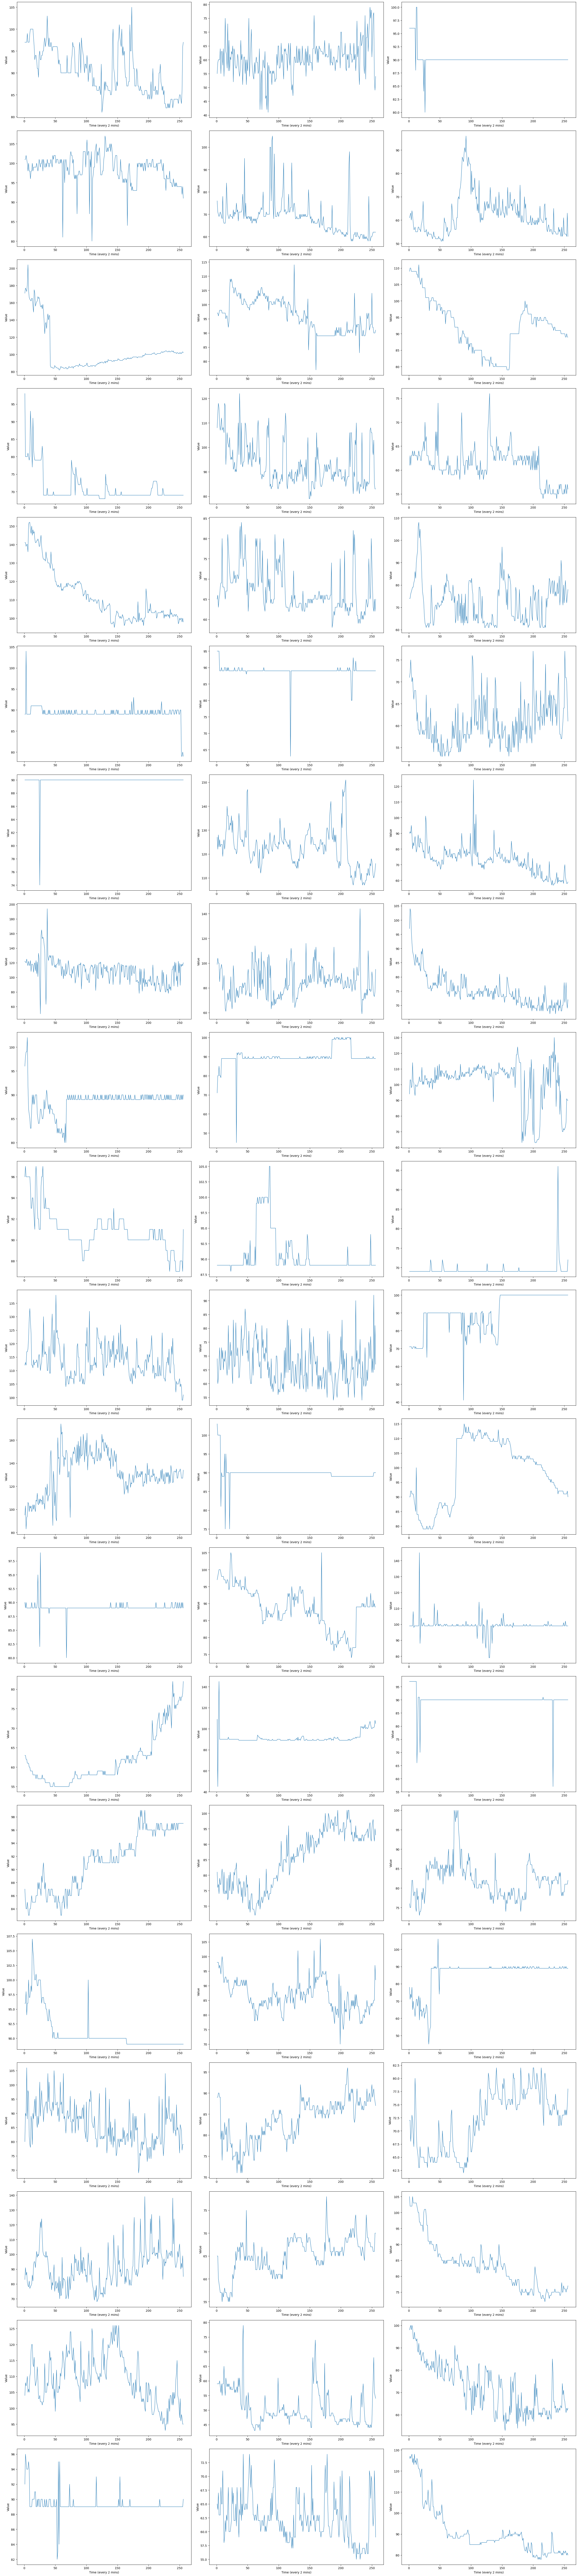

In [25]:
import numpy as np

rows = 20
cols = 3
visualize(samples, (rows, cols), figsize=(cols*9, rows*6), markersize=5, marker=None)

In [1]:
np.save('data/hirid_heartrate_2000_450.npy', samples)

NameError: name 'np' is not defined

In [13]:
import numpy as np
import torch

samples = np.load('data/hirid_heartrate_2000_450.npy')
samples = torch.from_numpy(samples).float()
samples

tensor([[97., 97., 97.,  ..., 92., 91., 91.],
        [55., 59., 60.,  ..., 54., 65., 61.],
        [96., 96., 96.,  ..., 73., 74., 74.],
        ...,
        [80., 80., 80.,  ..., 80., 81., 80.],
        [70., 70., 70.,  ..., 78., 78., 78.],
        [64., 59., 56.,  ..., 71., 67., 66.]])

In [14]:
samples = samples.unsqueeze(1)
samples.shape
samples = samples[:512, :, :400]
samples.shape
torch.save(samples, "data/hirid_heartrate_512_400.pt")

In [15]:
samples = torch.load("data/hirid_heartrate_512_400.pt")
samples.shape[0]
samples.shape

torch.Size([512, 1, 400])

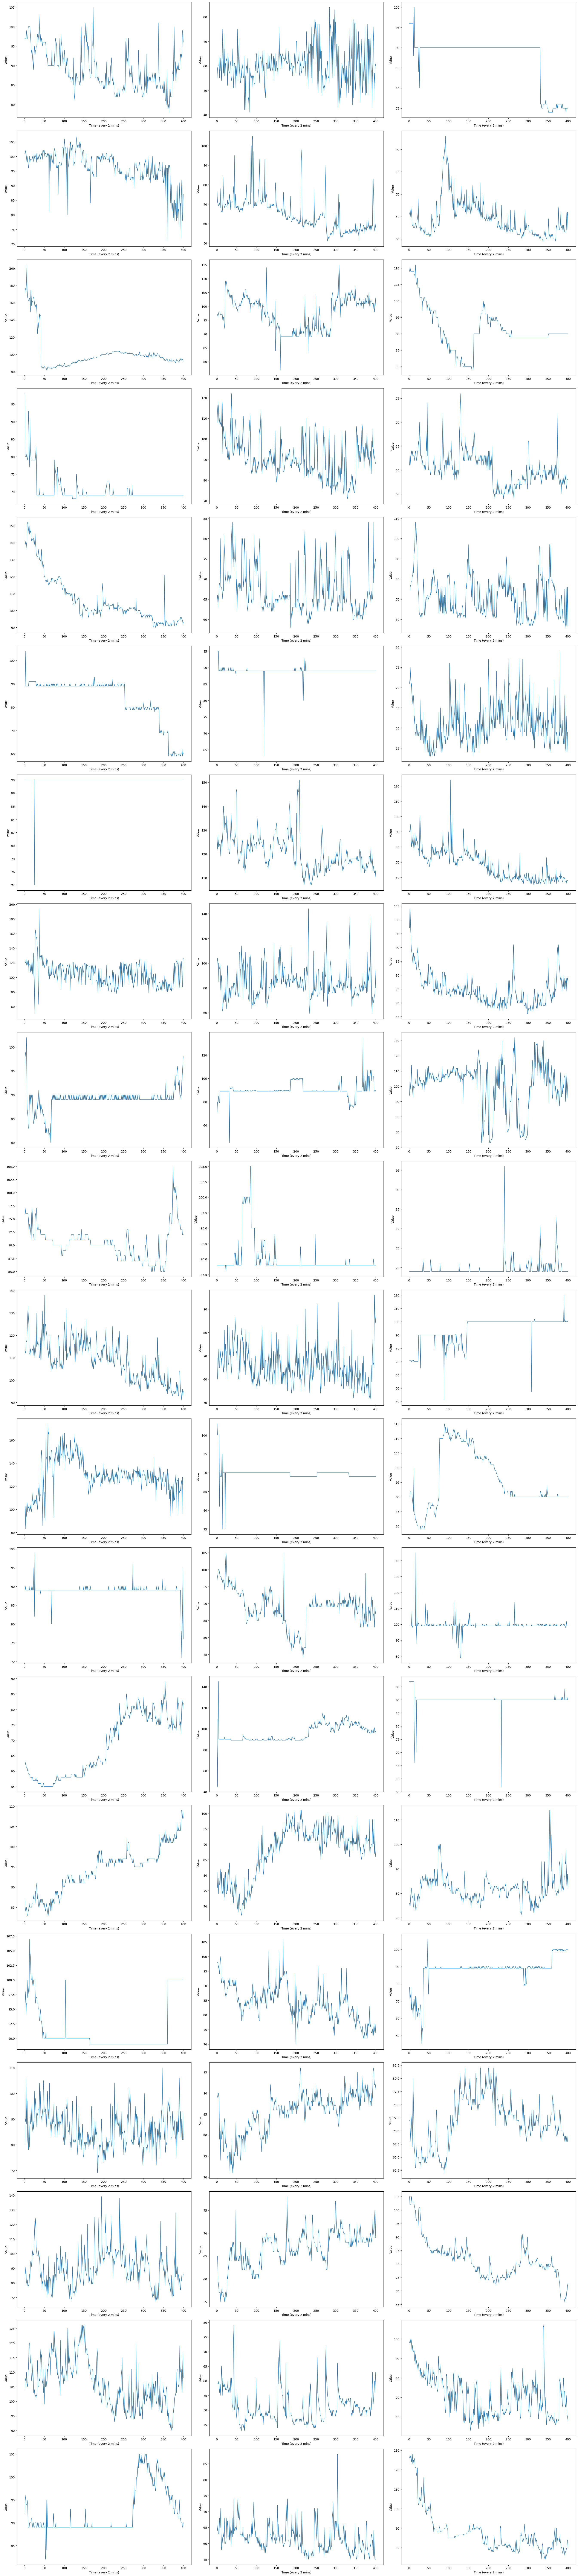

In [6]:

import torch
samples = torch.load("data/hirid_heartrate_256_400.pt").squeeze().numpy()
rows = 20
cols = 3
visualize(samples, (rows, cols), figsize=(cols*9, rows*6), markersize=5, marker=None)